In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cisc-873-dm-w24-a3/sample_submission.csv
/kaggle/input/cisc-873-dm-w24-a3/x_test.csv
/kaggle/input/cisc-873-dm-w24-a3/xy_train.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split,GridSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

**Read the data**

In [3]:
df=pd.read_csv('/kaggle/input/cisc-873-dm-w24-a3/xy_train.csv')
df2=pd.read_csv('/kaggle/input/cisc-873-dm-w24-a3/x_test.csv')

In [4]:
df

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0
...,...,...,...
59995,70046,Finish Sniper Simo H盲yh盲 during the invasion o...,0
59996,189377,Nigerian Prince Scam took $110K from Kansas ma...,1
59997,93486,Is It Safe To Smoke Marijuana During Pregnancy...,0
59998,140950,Julius Caesar upon realizing that everyone in ...,0


In [5]:
df2

,id,text
0,0,stargazer
1,1,yeah
2,2,PD: Phoenix car thief gets instructions from Y...
3,3,"As Trump Accuses Iran, He Has One Problem: His..."
4,4,"""Believers"" - Hezbollah 2011"
...,...,...
59146,59146,Bicycle taxi drivers of New Delhi
59147,59147,Trump blows up GOP's formula for winning House...
59148,59148,Napoleon returns from his exile on the island ...
59149,59149,Deep down he always wanted to be a ballet dancer


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60000 non-null  int64 
 1   text    60000 non-null  object
 2   label   60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


we don't have any nulls

In [9]:
df.duplicated().sum()

0

we don't have any duplicates in our data but let's cheak if we have duplicates in text column

In [4]:
df['text'].duplicated().sum()

355

we have some of them, let's drop it 

In [5]:
df.drop_duplicates('text', inplace=True)

let's cheak again

In [16]:
df['text'].duplicated().sum()

0

<Axes: xlabel='label', ylabel='count'>

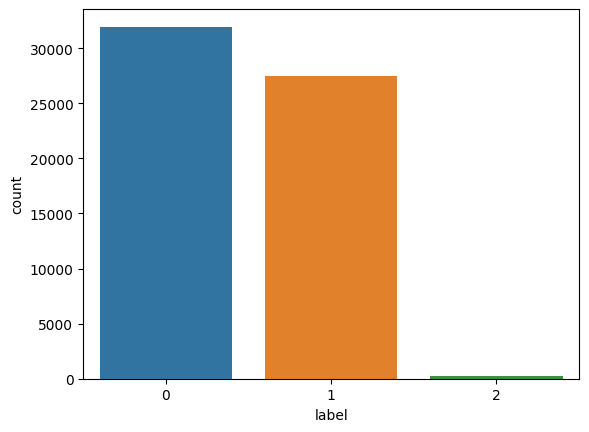

In [18]:
sns.countplot(data=df,x='label')

We can remove rows where the label equals 2 from the dataset to convert this into a binary classification problem.

In [6]:
indices_to_drop = df[df['label'] == 2].index
df = df.drop(indices_to_drop)

In [20]:
df['label'].unique()

array([0, 1])

# **Cleaning and preprocessing**


Create a function to clean training data by removing HTML tags, digits, and single letters, converting all text to lowercase, replacing multiple whitespaces with a single one, removing stopwords and punctuation, and applying stemming. This will help reduce noise and improve data quality for model training.

In [9]:
# required package for tokenization.
nltk.download('punkt') 
nltk.download('stopwords')

# for stemming algorithm
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))


# Make Function to clean text
def clean_text(text, for_embedding=False):
    """ steps:
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
        - return the clean text
    """
    re_wspace = re.compile(r"\s+", re.IGNORECASE)
    re_tags = re.compile(r"<[^>]+>")
    re_ASII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    re_single_char = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        re_ASII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        re_single_char = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(re_tags, " ", text)
    text = re.sub(re_ASII, " ", text)
    text = re.sub(re_single_char, " ", text)
    text = re.sub(re_wspace, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
%%time
# Clean texts training data 
df["text_clean"] = df.loc[df["text"].str.len() > 0, "text"] # get all text data the length it greater than 0 in training data
# call clean_text of method to apply it on text_clean feature in traing data
df["text_clean"] = df["text_clean"].map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x  # check if text is instance of string
) 

CPU times: user 31.5 s, sys: 18 ms, total: 31.5 s
Wall time: 31.5 s


In [26]:
df

,id,text,label,text_clean
0,265723,A group of friends began to volunteer at a hom...,0,group friend began volunt homeless shelter nei...
1,284269,British Prime Minister @Theresa_May on Nerve A...,0,british prime minist theresa may nerv attack f...
2,207715,"In 1961, Goodyear released a kit that allows P...",0,goodyear releas kit allow ps brought heel http...
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0,happi birthday bob barker price right host lik...
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0,obama nation innoc cop unarm young black men d...
...,...,...,...,...
59995,70046,Finish Sniper Simo H盲yh盲 during the invasion o...,0,finish sniper simo yh invas finland ussr color
59996,189377,Nigerian Prince Scam took $110K from Kansas ma...,1,nigerian princ scam took kansa man year later ...
59997,93486,Is It Safe To Smoke Marijuana During Pregnancy...,0,safe smoke marijuana pregnanc surpris answer
59998,140950,Julius Caesar upon realizing that everyone in ...,0,julius caesar upon realiz everyon room knife e...


In [11]:
%%time
# Clean texts testing data
df2["text_clean"] = df2.loc[df2["text"].str.len() > 0, "text"] # get all text data the length it greater than 0 in testing data
# call clean_text of method to apply it on text_clean feature in testing data
df2["text_clean"] = df2["text_clean"].map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x  # check if text is instance of string
)

CPU times: user 15.9 s, sys: 9.13 ms, total: 15.9 s
Wall time: 15.9 s


In [28]:
df2

,id,text,text_clean
0,0,stargazer,stargaz
1,1,yeah,yeah
2,2,PD: Phoenix car thief gets instructions from Y...,pd phoenix car thief get instruct youtub video
3,3,"As Trump Accuses Iran, He Has One Problem: His...",trump accus iran one problem credibl
4,4,"""Believers"" - Hezbollah 2011",believ hezbollah
...,...,...,...
59146,59146,Bicycle taxi drivers of New Delhi,bicycl taxi driver new delhi
59147,59147,Trump blows up GOP's formula for winning House...,trump blow gop formula win hous race
59148,59148,Napoleon returns from his exile on the island ...,napoleon return exil island elba march colouris
59149,59149,Deep down he always wanted to be a ballet dancer,deep alway want ballet dancer


# **Modeling**

In [12]:
#split the data into train and test using train_test_split
X = df['text']
# contain the label
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2)

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 7)

**Trail 1**

in this trail i will try CountVectorizer with XGBoost classifire

In [10]:
is_train = np.isin(X_train.index, X_train2.index)

split_index = np.where(is_train, -1, 0)

# Create the PredefinedSplit using the split index
split = PredefinedSplit(test_fold=split_index)

In [14]:
# creat pipeline with CountVectorizer
pipeline = Pipeline([
    ('cvec', CountVectorizer()),    
    ('xgboost', XGBClassifier(objective='binary:logistic'))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'xgboost__n_estimators': [300, 500], 
    'xgboost__max_depth': [20, 40, 60]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=split, verbose=2, scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Output the best score from the grid search and scores on train and test sets
print("Best score:", grid_search.best_score_)
print("Train score:", grid_search.score(X_train, y_train))
print("Test score:", grid_search.score(X_test, y_test))

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV] END ...xgboost__max_depth=40, xgboost__n_estimators=300; total time= 7.4min
[CV] END ...xgboost__max_depth=40, xgboost__n_estimators=500; total time= 9.8min
[CV] END ...xgboost__max_depth=20, xgboost__n_estimators=300; total time= 3.7min
[CV] END ...xgboost__max_depth=60, xgboost__n_estimators=300; total time= 8.1min
Best score: 0.8906109207462446
Train score: 0.9988543678705306
Test score: 0.9013679951749658


In [16]:
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = grid_search.predict_proba(df2['text'])[:, 1]

submission.to_csv('trail1.csv', index=False)

[CV] END ...xgboost__max_depth=20, xgboost__n_estimators=500; total time= 5.3min
[CV] END ...xgboost__max_depth=60, xgboost__n_estimators=500; total time= 9.7min


**trail 2**

i will try TfidfVectorizer and logistic regression to enhance the accuracy

In [18]:
# Define the pipeline with TF-IDF Vectorizer and Logistic Regression
pipeline = Pipeline([
    ('tfidf_vector', TfidfVectorizer()),  # Text vectorization
    ('lr', LogisticRegression(solver='liblinear'))  # Logistic regression model
])

# Define parameter grid for GridSearchCV
param_grid = {
    'tfidf_vector__max_df': [0.5, 0.6, 0.75, 0.98, 1.0],  
    'tfidf_vector__min_df': [2, 3, 5, 10],  
    'tfidf_vector__ngram_range': [(1, 1), (1, 2), (1, 3)],  
    'lr__C': [0.01, 1],  
    'lr__penalty': ['l2'], 
    'lr__solver': ['lbfgs', 'liblinear']  
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=split, verbose=2, scoring='roc_auc', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Output the best score from GridSearchCV and evaluate performance on training and test sets
print("Best score:", grid_search.best_score_)
print("Train score:", grid_search.score(X_train, y_train))
print("Test score:", grid_search.score(X_test, y_test))


Fitting 1 folds for each of 240 candidates, totalling 240 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tfidf_vector__max_df=0.5, tfidf_vector__min_df=2, tfidf_vector__ngram_range=(1, 2); total time=   5.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tfidf_vector__max_df=0.5, tfidf_vector__min_df=5, tfidf_vector__ngram_range=(1, 1); total time=   2.1s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tfidf_vector__max_df=0.5, tfidf_vector__min_df=5, tfidf_vector__ngram_range=(1, 3); total time=   7.5s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tfidf_vector__max_df=0.6, tfidf_vector__min_df=3, tfidf_vector__ngram_range=(1, 1); total time=   2.5s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tfidf_vector__max_df=0.6, tfidf_vector__min_df=3, tfidf_vector__ngram_range=(1, 2); total time=   5.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tfidf_vector__max_df=0.6, tfidf_vector__min_df=5, tfidf_vector__ngram_range=(1, 3); total time=   7.6s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfg

In [19]:
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = grid_search.predict_proba(df2['text'])[:, 1]

submission.to_csv('trail2.csv', index=False)

[CV] END lr__C=1, lr__penalty=l2, lr__solver=liblinear, tfidf_vector__max_df=0.75, tfidf_vector__min_df=3, tfidf_vector__ngram_range=(1, 3); total time=   7.4s
[CV] END lr__C=1, lr__penalty=l2, lr__solver=liblinear, tfidf_vector__max_df=0.98, tfidf_vector__min_df=2, tfidf_vector__ngram_range=(1, 1); total time=   2.3s
[CV] END lr__C=1, lr__penalty=l2, lr__solver=liblinear, tfidf_vector__max_df=0.98, tfidf_vector__min_df=2, tfidf_vector__ngram_range=(1, 2); total time=   5.1s
[CV] END lr__C=1, lr__penalty=l2, lr__solver=liblinear, tfidf_vector__max_df=0.98, tfidf_vector__min_df=5, tfidf_vector__ngram_range=(1, 1); total time=   2.3s
[CV] END lr__C=1, lr__penalty=l2, lr__solver=liblinear, tfidf_vector__max_df=0.98, tfidf_vector__min_df=5, tfidf_vector__ngram_range=(1, 2); total time=   4.7s
[CV] END lr__C=1, lr__penalty=l2, lr__solver=liblinear, tfidf_vector__max_df=1.0, tfidf_vector__min_df=2, tfidf_vector__ngram_range=(1, 1); total time=   2.3s
[CV] END lr__C=1, lr__penalty=l2, lr__sol

it's give me the best accuracy on the leaderboard

**trail 3** 

in this trail i'll switch to using CountVectorizer for feature extraction to evaluate the differences between utilizing 'word' and 'char' analyzers

In [11]:

tf_vector = TfidfVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 2), max_df=0.5, min_df=10)
X_transformed = tf_vector.fit_transform(X_train)
print('This vectorizer will produce', X_transformed.shape[1], 'columns.')


This vectorizer will produce 7778 columns.


In [12]:
tf_vector = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))
X_transformed = tf_vector.fit_transform(X_train)
print('This vectorizer will produce', X_transformed.shape[1], 'columns.')


This vectorizer will produce 735 columns.


In [13]:
# using the tfidf as vectorizer with char analyzer
pipe = Pipeline([('tfidf_vector', TfidfVectorizer( ngram_range=(1, 2))),    
                 #using logistic regression as model
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune by  GridSearchCV
pipe_params = {'tfidf_vector__analyzer':['char','word'],
    'lr__C': [0.01, 1],}


gs_trial = GridSearchCV(pipe, param_grid=pipe_params, cv=split,verbose=2,scoring='roc_auc',n_jobs=-1)
gs_trial.fit(X_train, y_train);
print("Best score:", gs_trial.best_score_)
print("Train score", gs_trial.score(X_train, y_train))
print("Test score", gs_trial.score(X_test, y_test))

Fitting 1 folds for each of 4 candidates, totalling 4 fits
Best score: 0.8708529752835528
Train score 0.9702667551580434
Test score 0.8733725410089437
[CV] END ............lr__C=0.01, tfidf_vector__analyzer=word; total time=   5.0s
[CV] END ...............lr__C=1, tfidf_vector__analyzer=word; total time=   5.2s
[CV] END ............lr__C=0.01, tfidf_vector__analyzer=char; total time=   6.8s
[CV] END ...............lr__C=1, tfidf_vector__analyzer=char; total time=   7.4s


In [24]:
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = grid_search.predict_proba(df2['text'])[:, 1]

submission.to_csv('trail3.csv', index=False)

[CV] END ............lr__C=0.01, tfidf_vector__analyzer=word; total time=   6.4s
[CV] END ...............lr__C=1, tfidf_vector__analyzer=word; total time=   7.0s
[CV] END ............lr__C=0.01, tfidf_vector__analyzer=char; total time=   9.3s
[CV] END ...............lr__C=1, tfidf_vector__analyzer=char; total time=  10.6s


**trail 4**

In this trial, I will evaluate the impact of stemming on text classification by experimenting with two different classifiers: RandomForest and SVM

In [7]:
# Initialize stemmer and stopwords
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower().split('\t')[0]
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"[^a-z ]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize, stem, and remove stopwords
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(stemmed)

# Load dataset and preprocess
df = pd.read_csv('/kaggle/input/cisc-873-dm-w24-a3/xy_train.csv')
df = df[df['label'] != 2]
df.drop_duplicates('text', inplace=True)
df['text'] = df['text'].apply(clean_text)

# Split dataset into features and target
X = df['text']
y = df['label']

# Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

# Further split training data into training and validation sets
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7, stratify=y_train)

# Create a PredefinedSplit based on the indices of X_train2
is_train = np.isin(X_train.index, X_train2.index)

split_index = np.where(is_train, -1, 0)

# Create the PredefinedSplit using the split index
split = PredefinedSplit(test_fold=split_index)




In [ ]:
from sklearn.svm import SVC

# Define the pipeline with a placeholder for the classifier
pipe = Pipeline([
    ('tfidf_vector', TfidfVectorizer()),    
    ('classifier', None)  # Placeholder for the classifier
])

# Define parameter grid with options for RandomForest and SVC
param_grid = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {
        'classifier': [SVC(probability=True)],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }
]

# Create a GridSearchCV object with the pipeline and parameter grid
gs_trial = GridSearchCV(pipe, param_grid=param_grid, cv=split, verbose=2, scoring='roc_auc', n_jobs=-1)

# Fit GridSearchCV to the training data
gs_trial.fit(X_train, y_train)

# Output the best score from GridSearchCV and evaluate performance on training and test sets
print("Best score:", gs_trial.best_score_)
print("Train score:", gs_trial.score(X_train, y_train))
print("Test score:", gs_trial.score(X_test, y_test))


Fitting 1 folds for each of 48 candidates, totalling 48 fits
[CV] END classifier=RandomForestClassifier(), classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=100; total time= 1.8min
[CV] END classifier=RandomForestClassifier(), classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=300; total time= 5.3min
[CV] END classifier=RandomForestClassifier(), classifier__max_depth=None, classifier__min_samples_split=10, classifier__n_estimators=300; total time= 4.5min


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = gs_trial.predict_proba(df2['text'])[:, 1]

submission.to_csv('trail6.csv', index=False)

AttributeError: predict_proba is not available when  probability=False

**trail 5**

In this trial, I will evaluate the impact of lematizing on text classification

In [3]:
# will lematizer the words
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words("english")) 
def clean_text(text):
     # lower case the text
    text=text.lower()
    line=text.split('\t')[0]

    # concat the list in one line
    text=''.join(line)

    # remove the special charachters
    text = re.sub(r'\W', ' ', str(text))

    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # remove the white spaces
    text= re.sub(r'\d+', '',text)
    # remove non english charachters
    text= re.sub(r"[^A-Za-zÀ-ž ]", ' ',text)
    # remove the white spaces
    text= re.sub(r'\s+', ' ',text)
    text = word_tokenize(text)
    text = [stemmer.stem(word) for word in text if word not in stop_words]

    text=' '.join(text)
       
    return text

     


In [7]:
df=pd.read_csv('/kaggle/input/cisc-873-dm-w24-a3/xy_train.csv')
df=df[df['label']!=2]
df.drop_duplicates('text', inplace=True)
df['text']=df['text'].apply(clean_text)
X = df['text']
# contain the label
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=7,stratify=y,test_size=0.2)

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 7)
split_index = [-1 if x in X_train2.index else 0 for x in X_train.index]
split= PredefinedSplit(test_fold = split_index)

In [8]:
# using the tfidf as vectorizer
pipe = Pipeline([('tfidf_vector', TfidfVectorizer()),    
                 #using random forest as model
                 ('rf', RandomForestClassifier())])

# Tune by  GridSearchCV
pipe_params = {'rf__n_estimators': [600],
              'rf__max_depth':[30,40,50]}

gs_trial = GridSearchCV(pipe, param_grid=pipe_params, cv=split,verbose=2,scoring='roc_auc',n_jobs=-1)
gs_trial.fit(X_train, y_train);
print("Best score:", gs_trial.best_score_)
print("Train score", gs_trial.score(X_train, y_train))
print("Test score", gs_trial.score(X_test, y_test))

Fitting 1 folds for each of 3 candidates, totalling 3 fits
Best score: 0.833046072037342
Train score 0.9520189435373383
Test score 0.8373534306146363


In [9]:
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = gs_trial.predict_proba(df2['text'])[:, 1]

submission.to_csv('trail5.csv', index=False)

[CV] END .............rf__max_depth=30, rf__n_estimators=600; total time=  36.4s


# Problem formulation:

### Define the problem:

- The dataset provided to us is the title of the news and a label of this title whether it is fake or not. Since spreading fake news is a big problem in our life, we aim to contribute to the solving of this problem through data mining and machine learning. Therefore, we can formulate a binary classification task that we have to address.

### what is the input?

- The input is a text feature. It encompasses various forms of words.

### what is the output ?
- A probability between 0-1 is used to determine if the news is fake or not. We can set a threshold to penalize fake news; for instance, if the model predicts that the title tends to be fake with a probability of 0.7 (though we often use 0.5), why not consider changing the threshold?

### what is the data mining function required ?

 - The binary classification function, which is the mining function employed in this challenge, was achieved by taking the following actions:
- **data gathering**
- **Data cleaning and preprocessing**

- **modeling** Identify the problem as a classification problem, ascertain the evaluation measure (in our instance, ACUC), and then experiment with various models using various hyperparameters and features using grid search, random search, and bayesian search techniques.
- **Model evaluation involves comparing the best scoring measure to determine which model is the best.


### what are the challanges?

- There are several word forms in the data.
- There are outlier values in the datasets.
- Determine whether a particular Reddit post is fake news or not based only on its title.

### what is the impact ?
- The creation of such a high-performance model will help to significantly reduce the spread of rumors and fake news, and thereby improve the user experience on various platforms.

### what is the ideal solution ?
- The ideal solution would be to have a large, clean dataset and high-performance computing resources to develop a model capable of easily classifying fake news. However, the approach I was able to implement involved using logistic regression with TF-IDF. I also explored the state-of-the-art in deep learning, specifically BERT via transfer learning, but it did not yield satisfactory results.


### what is th experimental protocol used ?What preprocessing steps are used?
To compare many treatments using different models and attributes to one outcome, the AUC score, we used a pre-experimental approach. Here's how this procedure was carried out:

Prepare and handle the experiment's data:
- Eliminate duplicates.
- Respond to texts with a '2' label, whose veracity was questioned.
- Make use of diverse embeddings produced by different analyzers and algorithms.
- Get rid of stop words.
- Take out the new lines and tabs.
- Special characters should be removed.
- Take out any characters that are not in English.
- Texts with more words than a certain amount are excluded.
- To choose the best model, create a variety of models and keep an eye on the AUC score.

**Questions**

### Q1)What is the difference between Character n-gram and Word n-gram? Which one tends to suffer more from the OOV issue?
- Despite the fact that they are both feature extraction techniques used in natural language processing, the characteristics could be different. N-gram could be defined as a set of co-occurring words within a given window, and the window size could be 1 unigram,2 bigram ,…. so we can say the size of the windows depends and determined by n. Unigrams (n-gram size = 1), Bigrams, terms compounded by two words (n-gram size = 2), Trigrams, terms compounded by up to three words (n-gram size = 3), char n-gram, counting sequences of characters, word n-gram, counting sequences of words, but they produce different embeddings of course, most of the time word n-gram produce very sparse matrix, and as there is a huge number of words in every language, and in data mining we only work on sample not the whole population, we might see OOV (Out Of Vocabulary) issue, that is probably we may see new words which we didn’t see in the training, so char n-gram may handle this issue, as the probability of seeing new character sequence is much less than the probability of seeing new word sequence

### Q2) What is the difference between stop word removal and stemming? Are these techniques language-dependent?
- Stop word removal involves removing words that frequently occur across documents and do not significantly alter the context of sentences. These words, such as "the," "a," "have," and "always" in English, are primarily used to maintain grammatical structure in text. In natural language processing (NLP), the focus is more on the action or the type of word rather than its placement or timing, helping to maintain context integrity without creating biased embeddings.

- Stemming reduces words to their stem form by removing suffixes and prefixes, which helps in text normalization. For instance, "played," "play," "player," and "plays" all derive from the same root "play," and stemming them consolidates their representation, enhancing the consistency in embeddings.

- Both techniques are language-dependent. For example, stop words in Arabic differ significantly from those in English. Additionally, languages that use the Latin alphabet may still have different stopwords or stem forms, underscoring the need for language-specific processing tools. Similarly, a stemming algorithm designed for English cannot be used for Spanish as it would not correctly interpret the root forms of Spanish words
### Q3) Is tokenization techniques language dependent? Why?
- Tokenization involves splitting a piece of text into individual words using specific delimiters like spaces, commas, or tabs. This process results in the formation of word-level tokens, which are dependent on the language structure. For instance, while English words are typically separated by spaces, Chinese text is written without spaces between successive characters and words, posing a unique challenge for tokenization.
### Q4 )What is the difference between count vectorizer and tf-idf vectorizer? Would it be feasible to use all possible n-grams? If not, how should you select them?
- CountVectorizer: This method calculates the frequency of each word to create a representation based on embeddings. It's a straightforward approach to understanding text data by evaluating how often words appear.
- TFIDF (Term Frequency-Inverse Document Frequency): This technique transforms a collection of raw documents into a matrix of TF-IDF features. It focuses on the frequency of words and their relative importance across documents. By emphasizing significant words and ignoring less relevant ones, TFIDF reduces the dimensionality of the model, simplifying the model building process.
- Regarding the use of all possible n-grams, it's impractical because the size of the feature space would grow exponentially. Therefore, it's common to select an appropriate n-gram size as a hyperparameter and optimize it based on the specific needs of the task. For instance, in sentiment analysis, using bigrams or trigrams can significantly enhance classification accuracy by capturing more complex expressions that single words alone might miss.
